## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw
from salishsea_tools import geo_tools

%matplotlib inline

In [2]:
PATH= '/results/SalishSea/hindcast.201812/'
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2018,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO()
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
data=df1.loc[(df1.Lon>-125)|(df1.Lat>49.3)]
data['exSi']=data['Si']-1.3*data['N']

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
# choose data in model
meshPath='/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc'
maskName='tmask'
mod_start=start_date
mod_end=end_date
# adjustments to data dataframe
data=data.loc[(data.dtUTC>=mod_start)&(data.dtUTC<mod_end)].copy(deep=True)
data=data.dropna(how='any',subset=['dtUTC','Lat','Lon','Z']) #.dropna(how='all',subset=[*varmap.keys()])
data['j']=-1*np.ones((len(data))).astype(int)
data['i']=-1*np.ones((len(data))).astype(int)
with nc.Dataset(meshPath) as fmesh:
    omask=np.copy(fmesh.variables[maskName])
    lmask=-1*(omask[0,0,:,:]-1)
    for la,lo in np.unique(data.loc[:,['Lat','Lon']].values,axis=0):
        jj, ii = geo_tools.find_closest_model_point(lo, la, fmesh.variables['nav_lon'], fmesh.variables['nav_lat'], 
                                                    land_mask = lmask)
        if isinstance(jj,int):
            data.loc[(data.Lat==la)&(data.Lon==lo),['j','i']]=jj,ii
        else:
            print('(Lat,Lon)=',la,lo,' not matched to domain')
data.drop(data.loc[(data.i==-1)&(data.j==-1)].index, inplace=True)
data=data.sort_values(by=['dtUTC','Z','j','i'])
data.reset_index(drop=True,inplace=True)

(Lat,Lon)= 50.4882 -126.3484  not matched to domain
(Lat,Lon)= 50.6318 -126.4979  not matched to domain
(Lat,Lon)= 50.8046 -126.5291  not matched to domain
(Lat,Lon)= 50.8762 -126.6183  not matched to domain
(Lat,Lon)= 50.9086 -126.5451  not matched to domain


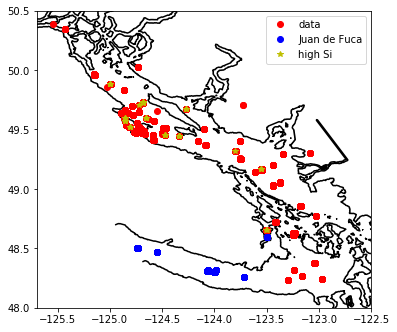

In [5]:

fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

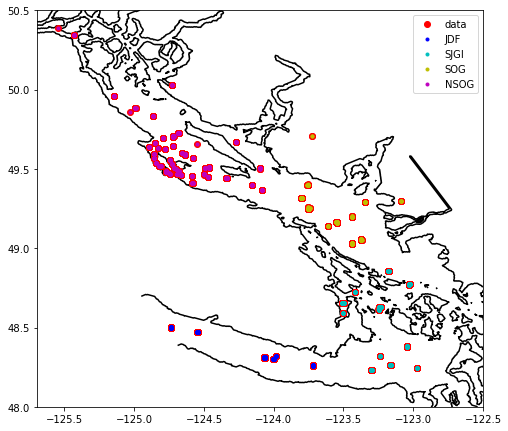

In [6]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [7]:
# load EC Rivers database
dbpath='/ocean/eolson/MEOPAR/obs/ECRivers/ECRiversDB'
engine = create_engine('sqlite:///'+dbpath+'.sqlite')
Base = automap_base()
Base.prepare(engine, reflect=True)
Profs=Base.classes.profiles
session = create_session(bind = engine, autocommit = False, autoflush = True)


# NO2+NO3 at Hope and Gravesend
dataN=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value,Profs.station_name).\
            filter(and_(
                Profs.value<2.5, # remove single high outlier
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                or_(Profs.station_name.like('%Gravesend%'),
                    Profs.station_name.like('%Hope%')))).all()
dfNO3=pd.DataFrame(dataN)


# Si at Hope and Gravesend
dataSi=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value,Profs.station_name).\
            filter(and_(
                or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED'),
                or_(Profs.station_name.like('%Gravesend%'),
                    Profs.station_name.like('%Hope%')))).all()
dfSi=pd.DataFrame(dataSi)
    
#YD=np.concatenate((YDG,YDH))
#val=np.concatenate((valG, valH))
#sidict=gsmooth(YD,val,60)

In [8]:
dfSi.head(),dfNO3.head()

(   Year  Month  Day  value          station_name
 0  1991      3    8   4.04  Fraser River at Hope
 1  1991      3   21   4.21  Fraser River at Hope
 2  1991      4    4   4.93  Fraser River at Hope
 3  1991      4   18   5.04  Fraser River at Hope
 4  1991      4   30   5.68  Fraser River at Hope,
    Year  Month  Day  value          station_name
 0  1979      7   17  0.051  Fraser River at Hope
 1  1979     10   10  0.042  Fraser River at Hope
 2  1979     10   31  0.050  Fraser River at Hope
 3  1979     11   20  0.035  Fraser River at Hope
 4  1979     12   20  0.087  Fraser River at Hope)

In [9]:
#/mwN*1000.0
#/mwSiO2*1000.0
mwN=14.006720
#mwSiO3=76.083820
mwSiO2=60.08
dfRiv=dfSi.merge(dfNO3,on=('Year','Month','Day','station_name'))
dfRiv['NO3']=dfRiv['value_y']/mwN*1000.0
dfRiv['Si']=dfRiv['value_x']/mwSiO2*1000.0
dfRiv['dt']=[dt.datetime(yy,mm,dd) for yy,mm,dd in zip(dfRiv['Year'],dfRiv['Month'],dfRiv['Day'])]
dfNO3['dt']=[dt.datetime(yy,mm,dd) for yy,mm,dd in zip(dfNO3['Year'],dfNO3['Month'],dfNO3['Day'])]
dfSi['dt']=[dt.datetime(yy,mm,dd) for yy,mm,dd in zip(dfSi['Year'],dfSi['Month'],dfSi['Day'])]

In [10]:
dfRiv.head()

,Year,Month,Day,value_x,station_name,value_y,NO3,Si,dt
0,1991,3,8,4.04,Fraser River at Hope,0.139,9.923808,67.243675,1991-03-08
1,1991,3,21,4.21,Fraser River at Hope,0.116,8.281739,70.073236,1991-03-21
2,1991,4,4,4.93,Fraser River at Hope,0.102,7.282219,82.057257,1991-04-04
3,1991,4,18,5.04,Fraser River at Hope,0.148,10.566357,83.888149,1991-04-18
4,1991,4,30,5.68,Fraser River at Hope,0.152,10.851934,94.540613,1991-04-30


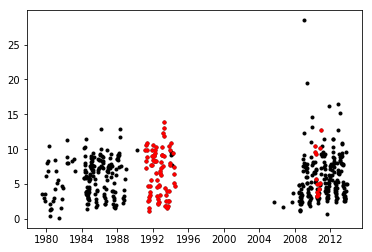

In [11]:
plt.plot(dfNO3['dt'],dfNO3['value']/mwN*1000.0,'k.')
plt.plot(dfRiv['dt'],dfRiv['NO3'],'r.')

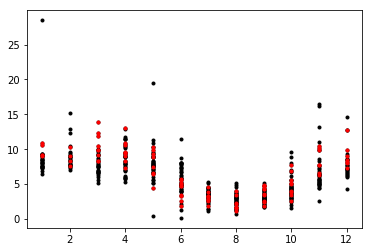

In [12]:
plt.plot(dfNO3['Month'],dfNO3['value']/mwN*1000.0,'k.')
plt.plot(dfRiv['Month'],dfRiv['NO3'],'r.')

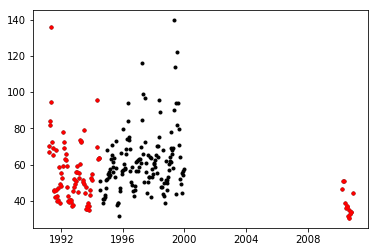

In [13]:
plt.plot(dfSi['dt'],dfSi['value']/mwSiO2*1000.0,'k.')
plt.plot(dfRiv['dt'],dfRiv['Si'],'r.')

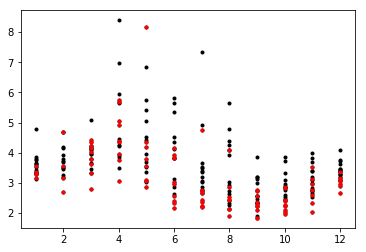

In [14]:
plt.plot(dfSi['Month'],dfSi['value'],'k.')
plt.plot(dfRiv['Month'],dfRiv['Si']*mwSiO2/1000.0,'r.')

(0, 85)

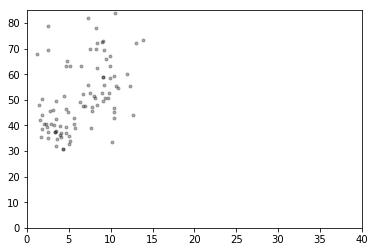

In [15]:
plt.plot(dfRiv['NO3'],dfRiv['Si'],'k.',alpha=.3)
plt.xlim(0,40)
plt.ylim(0,85)

# Ratios

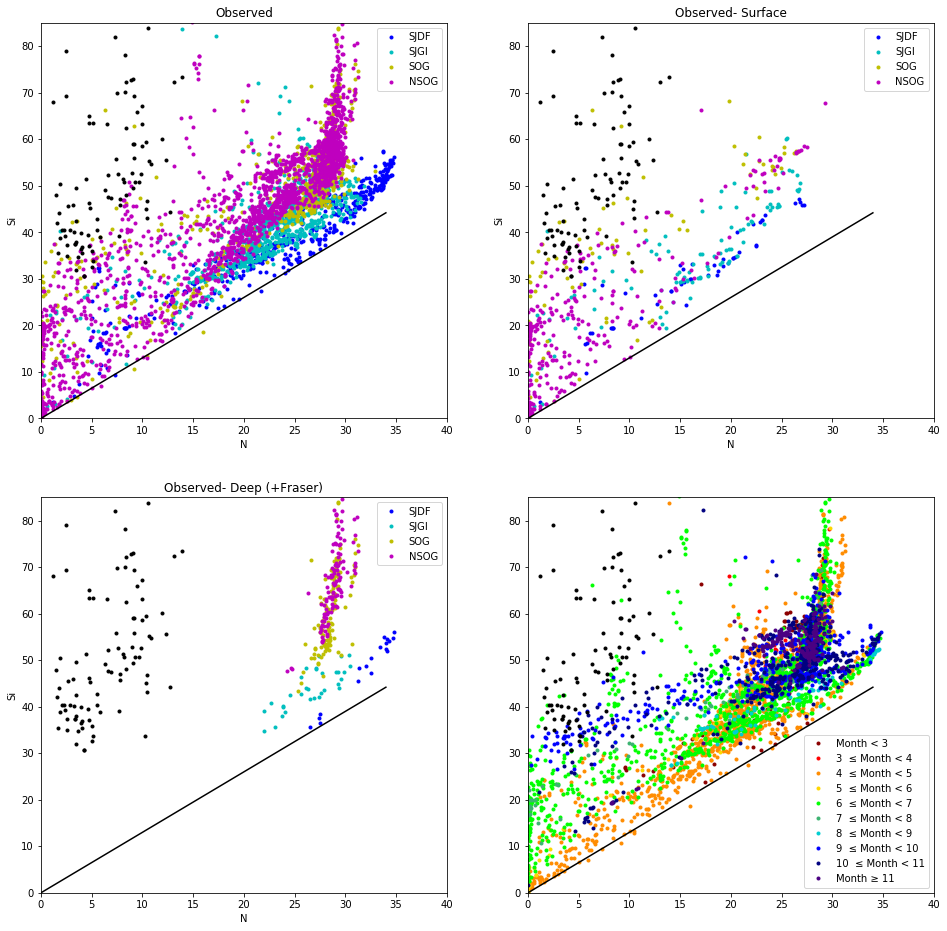

In [16]:
fig,ax=plt.subplots(2,2,figsize=(16,16))
p1=ax[0,0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0,0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0,0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0,0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0,0].set_title('Observed')
ax[0,0].set_xlabel('N')
ax[0,0].set_ylabel('Si')
ax[0,0].set_xlim(0,40)
ax[0,0].set_ylim(0,85)
ax[0,0].legend()
ax[0,0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[0,0].plot(dfRiv['NO3'],dfRiv['Si'],'k.')

p1=ax[1,0].plot(dJDF.loc[dJDF.Z>200]['N'],dJDF.loc[dJDF.Z>200]['Si'],'b.',label='SJDF')
p2=ax[1,0].plot(dSJGI.loc[dSJGI.Z>200]['N'],dSJGI.loc[dSJGI.Z>200]['Si'],'c.',label='SJGI')
p3=ax[1,0].plot(dSOG.loc[dSOG.Z>200]['N'],dSOG.loc[dSOG.Z>200]['Si'],'y.',label='SOG')
p4=ax[1,0].plot(dNSOG.loc[dNSOG.Z>200]['N'],dNSOG.loc[dNSOG.Z>200]['Si'],'m.',label='NSOG')
ax[1,0].set_title('Observed- Deep (+Fraser)')
ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel('Si')
ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,85)
ax[1,0].legend()
ax[1,0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1,0].plot(dfRiv['NO3'],dfRiv['Si'],'k.')


p1=ax[0,1].plot(dJDF.loc[dJDF.Z<5]['N'],dJDF.loc[dJDF.Z<5]['Si'],'b.',label='SJDF')
p2=ax[0,1].plot(dSJGI.loc[dSJGI.Z<5]['N'],dSJGI.loc[dSJGI.Z<5]['Si'],'c.',label='SJGI')
p3=ax[0,1].plot(dSOG.loc[dSOG.Z<5]['N'],dSOG.loc[dSOG.Z<5]['Si'],'y.',label='SOG')
p4=ax[0,1].plot(dNSOG.loc[dNSOG.Z<5]['N'],dNSOG.loc[dNSOG.Z<5]['Si'],'m.',label='NSOG')
ax[0,1].set_title('Observed- Surface')
ax[0,1].set_xlabel('N')
ax[0,1].set_ylabel('Si')
ax[0,1].set_xlim(0,40)
ax[0,1].set_ylim(0,85)
ax[0,1].legend()
ax[0,1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[0,1].plot(dfRiv['NO3'],dfRiv['Si'],'k.')

ps=et.varvarPlot(ax[1,1],data,'N','Si','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))
ax[1,1].set_xlim(0,40)
ax[1,1].set_ylim(0,85)
ax[1,1].legend()
ax[1,1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1,1].plot(dfRiv['NO3'],dfRiv['Si'],'k.')

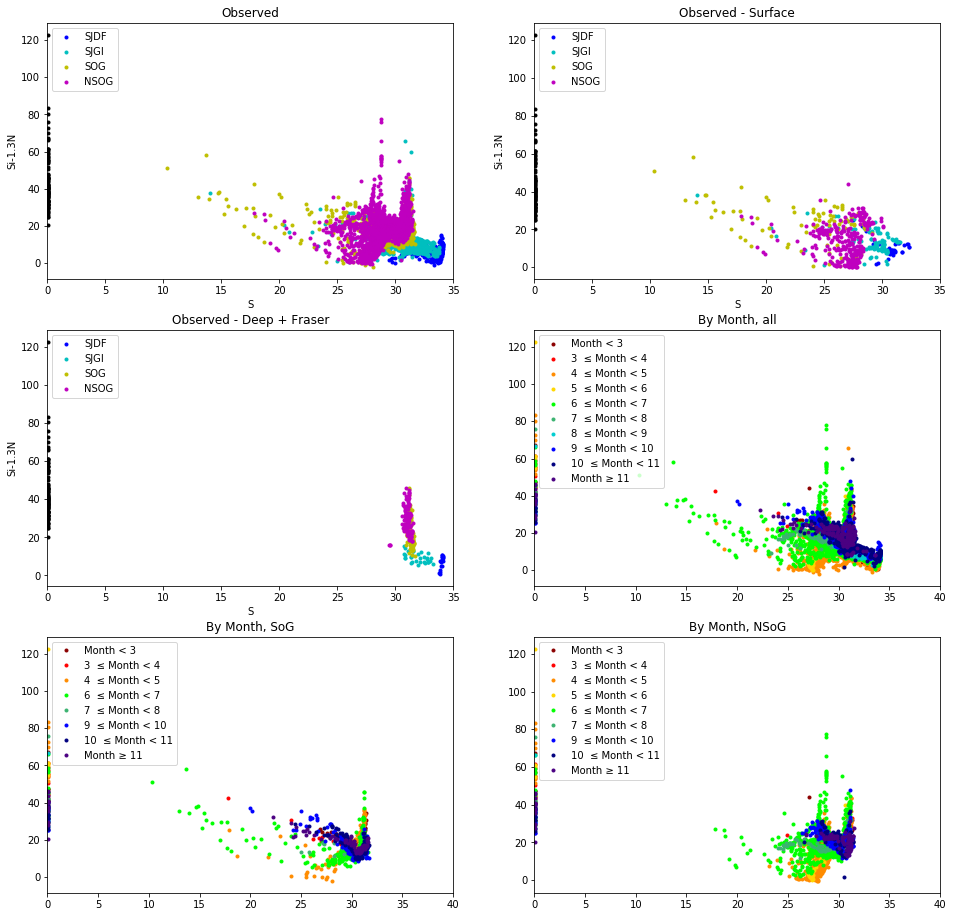

In [28]:
fig,ax=plt.subplots(3,2,figsize=(16,16))
p1=ax[0,0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0,0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0,0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0,0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0,0].set_title('Observed')
ax[0,0].set_xlabel('S')
ax[0,0].set_ylabel('Si-1.3N')
ax[0,0].set_xlim(0,35)
#ax[0,0].set_ylim(0,45)
ax[0,0].legend(loc=2)
ax[0,0].plot(0.1*np.ones(np.shape(dfRiv['NO3'])),dfRiv['Si']-1.3*dfRiv['NO3'],'k.')

p1=ax[0,1].plot(dJDF.loc[dJDF.Z<5]['AbsSal'], dJDF.loc[dJDF.Z<5]['Si']-1.3*dJDF.loc[dJDF.Z<5]['N'],'b.',label='SJDF')
p2=ax[0,1].plot(dSJGI.loc[dSJGI.Z<5]['AbsSal'],dSJGI.loc[dSJGI.Z<5]['Si']-1.3*dSJGI.loc[dSJGI.Z<5]['N'],'c.',label='SJGI')
p3=ax[0,1].plot(dSOG.loc[dSOG.Z<5]['AbsSal'],dSOG.loc[dSOG.Z<5]['Si']-1.3*dSOG.loc[dSOG.Z<5]['N'],'y.',label='SOG')
p4=ax[0,1].plot(dNSOG.loc[dNSOG.Z<5]['AbsSal'],dNSOG.loc[dNSOG.Z<5]['Si']-1.3*dNSOG.loc[dNSOG.Z<5]['N'],'m.',label='NSOG')
ax[0,1].set_title('Observed - Surface')
ax[0,1].set_xlabel('S')
ax[0,1].set_ylabel('Si-1.3N')
ax[0,1].set_xlim(0,35)
#ax[0,1].set_ylim(0,45)
ax[0,1].legend(loc=2)
ax[0,1].plot(0.1*np.ones(np.shape(dfRiv['NO3'])),dfRiv['Si']-1.3*dfRiv['NO3'],'k.')

p1=ax[1,0].plot(dJDF.loc[dJDF.Z>200]['AbsSal'], dJDF.loc[dJDF.Z>200]['Si']-1.3*dJDF.loc[dJDF.Z>200]['N'],'b.',label='SJDF')
p2=ax[1,0].plot(dSJGI.loc[dSJGI.Z>200]['AbsSal'],dSJGI.loc[dSJGI.Z>200]['Si']-1.3*dSJGI.loc[dSJGI.Z>200]['N'],'c.',label='SJGI')
p3=ax[1,0].plot(dSOG.loc[dSOG.Z>200]['AbsSal'],dSOG.loc[dSOG.Z>200]['Si']-1.3*dSOG.loc[dSOG.Z>200]['N'],'y.',label='SOG')
p4=ax[1,0].plot(dNSOG.loc[dNSOG.Z>200]['AbsSal'],dNSOG.loc[dNSOG.Z>200]['Si']-1.3*dNSOG.loc[dNSOG.Z>200]['N'],'m.',label='NSOG')
ax[1,0].set_title('Observed - Deep + Fraser')
ax[1,0].set_xlabel('S')
ax[1,0].set_ylabel('Si-1.3N')
ax[1,0].set_xlim(0,35)
#ax[1,0].set_ylim(0,45)
ax[1,0].legend(loc=2)
ax[1,0].plot(0.1*np.ones(np.shape(dfRiv['NO3'])),dfRiv['Si']-1.3*dfRiv['NO3'],'k.')

dfRiv['AbsSal']=0.1
dfRiv['exSi']=dfRiv['Si']-1.3*dfRiv['NO3']
ps=et.varvarPlot(ax[1,1],data,'AbsSal','exSi','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))
ax[1,1].set_xlim(0,40)
#ax[1,1].set_ylim(0,85)
ax[1,1].set_title('By Month, all')
ax[1,1].legend(loc=2)
ps2=et.varvarPlot(ax[1,1],dfRiv,'AbsSal','exSi','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))

ps=et.varvarPlot(ax[2,0],dSOG,'AbsSal','exSi','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))
ax[2,0].set_xlim(0,40)
#ax[2,0].set_ylim(0,85)
ax[2,0].set_title('By Month, SoG')
ax[2,0].legend(loc=2)
ps2=et.varvarPlot(ax[2,0],dfRiv,'AbsSal','exSi','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))

ps=et.varvarPlot(ax[2,1],dNSOG,'AbsSal','exSi','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))
ax[2,1].set_xlim(0,40)
#ax[2,1].set_ylim(0,85)
ax[2,1].set_title('By Month, NSoG')
ax[2,1].legend(loc=2)
ps2=et.varvarPlot(ax[2,1],dfRiv,'AbsSal','exSi','Month',np.arange(3,12),'Month','',('darkred','red','darkorange','gold','lime','mediumseagreen','darkturquoise','blue','navy','indigo','orchid','fucshia'))


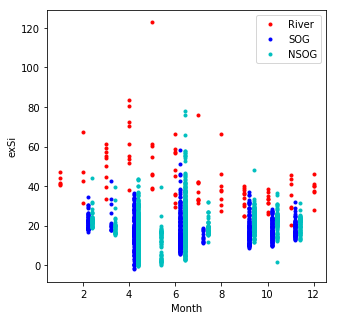

In [36]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(dfRiv['Month'],dfRiv['exSi'],'r.',label='River')
ax.plot(dSOG['Month']+.2,dSOG['exSi'],'b.',label='SOG')
ax.plot(dNSOG['Month']+.4,dNSOG['exSi'],'c.',label='NSOG')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('exSi')